In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Original x_train shape: {x_train.shape}")
print(f"Original y_train shape: {y_train.shape}")

Original x_train shape: (60000, 28, 28)
Original y_train shape: (60000,)


In [ ]:
num_samples_per_digit = 1000
selected_images = []
selected_labels = []

for digit in range(10):
    # Get indices for the current digit
    digit_indices = np.where(y_train == digit)[0]
    # Randomly select 'num_samples_per_digit' indices
    if len(digit_indices) >= num_samples_per_digit:
        chosen_indices = np.random.choice(digit_indices, num_samples_per_digit, replace=False)
    else:
        # If fewer than 1000 available, take all of them
        chosen_indices = digit_indices
        print(f"Warning: Only {len(digit_indices)} images available for digit {digit}. Taking all.")

    selected_images.append(x_train[chosen_indices])
    selected_labels.append(y_train[chosen_indices])

# Concatenate the selected images and labels
X = np.concatenate(selected_images, axis=0)
Y = np.concatenate(selected_labels, axis=0)

print(f"Dataset created with {X.shape[0]} images.")
print(f"Shape of selected images: {X.shape}")
print(f"Shape of selected labels: {Y.shape}")

Dataset created with 10000 images.
Shape of selected images: (10000, 28, 28)
Shape of selected labels: (10000,)


Shape of resized and binarized images: (10000, 14, 14)


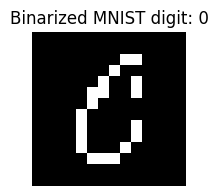

First 5 images and their labels:


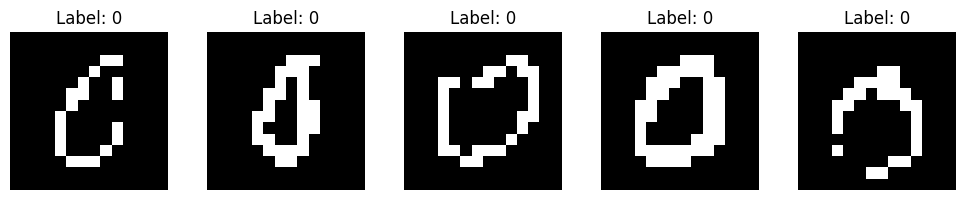

In [ ]:
target_size = (14, 14)
binary_threshold = 128

# Normalize images to [0, 1] first for resizing, then scale to 0-255 for binarization
X_resized = tf.image.resize(np.expand_dims(X, axis=-1), target_size).numpy()
# Remove the last dimension if it was added for tf.image.resize (channels=1)
if X_resized.shape[-1] == 1:
    X_resized = X_resized.squeeze(axis=-1)

# Binarize the resized images
X_binarized = (X_resized > binary_threshold).astype(np.float32)

print(f"Shape of resized and binarized images: {X_binarized.shape}")

# Display an example image
plt.figure(figsize=(2, 2))
plt.imshow(X_binarized[0], cmap='gray')
plt.title(f"Binarized MNIST digit: {Y[0]}")
plt.axis('off')
plt.show()

print("First 5 images and their labels:")
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(X_binarized[i], cmap='gray')
    axes[i].set_title(f"Label: {Y[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("PyTorch libraries imported successfully.")

# Convert X_binarized to PyTorch Tensor and reshape
X_binarized_tensor = torch.tensor(X_binarized, dtype=torch.float32)
# Reshape from (num_samples, 14, 14) to (num_samples, 196)
X_binarized_tensor = X_binarized_tensor.view(X_binarized_tensor.shape[0], -1)

print(f"Shape of X_binarized_tensor: {X_binarized_tensor.shape}")

# Create a custom PyTorch Dataset class
class MNISTDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Instantiate the custom Dataset
mnist_dataset = MNISTDataset(X_binarized_tensor)

print(f"Number of samples in MNISTDataset: {len(mnist_dataset)}")

# Create a DataLoader
batch_size = 64
mnist_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

print(f"DataLoader created with batch_size={batch_size}.")

# Displaying one batch to verify
for i, batch in enumerate(mnist_dataloader):
    print(f"Shape of batch {i+1}: {batch.shape}")
    break

PyTorch libraries imported successfully.
Shape of X_binarized_tensor: torch.Size([10000, 196])
Number of samples in MNISTDataset: 10000
DataLoader created with batch_size=64.
Shape of batch 1: torch.Size([64, 196])


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # Flatten the input (if not already flattened)
        # For this task, X_binarized_tensor is already flattened to 196
        # So, we expect x to be (batch_size, 196)
        h = self.tanh(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

# Instantiate the Encoder to demonstrate its structure
input_dim = 196
hidden_dim = 128
latent_dim = 8  # This is for mu and log_var each, total output 16

encoder = Encoder(input_dim, hidden_dim, latent_dim)
print(f"Encoder architecture: {encoder}")

# Test with a dummy input
dummy_input = torch.randn(1, input_dim) # Batch size of 1
mu, log_var = encoder(dummy_input)
print(f"\nShape of mu from encoder: {mu.shape}")
print(f"Shape of log_var from encoder: {log_var.shape}")

Encoder architecture: Encoder(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (tanh): Tanh()
  (fc_mu): Linear(in_features=128, out_features=8, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=8, bias=True)
)

Shape of mu from encoder: torch.Size([1, 8])
Shape of log_var from encoder: torch.Size([1, 8])


In [ ]:
def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z

print("Reparameterization trick function defined.")

# Test the reparameterize function
dummy_mu = torch.zeros(1, latent_dim)
dummy_log_var = torch.zeros(1, latent_dim)

z_sample = reparameterize(dummy_mu, dummy_log_var)
print(f"\nShape of sampled latent variable z: {z_sample.shape}")
print(f"Example of sampled z: {z_sample}")

Reparameterization trick function defined.

Shape of sampled latent variable z: torch.Size([1, 8])
Example of sampled z: tensor([[ 0.5899, -0.2588,  0.5942, -0.0111, -1.7610, -1.0101, -0.3373, -1.3430]])


In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.tanh(self.fc1(z))
        reconstruction = self.sigmoid(self.fc2(h))
        return reconstruction

# Instantiate the Decoder
decoder = Decoder(input_dim, hidden_dim, latent_dim)
print(f"Decoder architecture: {decoder}")

# Test with a dummy latent variable input
dummy_z = torch.randn(1, latent_dim) # Batch size of 1
reconstructed_output = decoder(dummy_z)
print(f"\nShape of reconstructed output from decoder: {reconstructed_output.shape}")

Decoder architecture: Decoder(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (tanh): Tanh()
  (fc2): Linear(in_features=128, out_features=196, bias=True)
  (sigmoid): Sigmoid()
)

Shape of reconstructed output from decoder: torch.Size([1, 196])


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = reparameterize(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

# Instantiate the VAE model
vae_model = VAE(input_dim, hidden_dim, latent_dim)
print(f"VAE architecture: {vae_model}")

# Test with a dummy input
dummy_input_vae = torch.randn(batch_size, input_dim) # Use the defined batch_size
reconstruction, mu, log_var = vae_model(dummy_input_vae)

print(f"\nShape of reconstruction from VAE: {reconstruction.shape}")
print(f"Shape of mu from VAE: {mu.shape}")
print(f"Shape of log_var from VAE: {log_var.shape}")

VAE architecture: VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=196, out_features=128, bias=True)
    (tanh): Tanh()
    (fc_mu): Linear(in_features=128, out_features=8, bias=True)
    (fc_log_var): Linear(in_features=128, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=128, bias=True)
    (tanh): Tanh()
    (fc2): Linear(in_features=128, out_features=196, bias=True)
    (sigmoid): Sigmoid()
  )
)

Shape of reconstruction from VAE: torch.Size([64, 196])
Shape of mu from VAE: torch.Size([64, 8])
Shape of log_var from VAE: torch.Size([64, 8])


In [ ]:
import torch.nn.functional as F

def vae_loss(reconstruction, x, mu, log_var):
    # 1. Reconstruction loss (Bernoulli cross-entropy)
    # F.binary_cross_entropy expects input and target to have the same shape
    # reduction='sum' sums over all elements in the batch
    reconstruction_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')

    # 2. KL divergence loss
    # 0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # 3. Total VAE loss
    total_loss = reconstruction_loss + kl_divergence

    # Divide by batch size to get average loss per sample
    return total_loss / x.size(0), reconstruction_loss / x.size(0), kl_divergence / x.size(0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model initialization
vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device)

# Optimizer setup
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

# Training parameters
epochs = 100 # Define number of epochs

# 1. Initialize lists to store metrics and a weight update counter
training_recon_losses = []
training_kl_divergences = []
validation_log_likelihoods = []
weight_update_counter = 0

print(f"Starting VAE training for {epochs} epochs...")

# Move validation tensor to device once
x_val_100_tensor = x_val_100_tensor.to(device)

# Training loop
for epoch in range(epochs):
    vae_model.train()
    total_epoch_loss = 0
    total_epoch_recon_loss = 0
    total_epoch_kl_div = 0

    for batch_idx, data in enumerate(mnist_dataloader):
        data = data.to(device)

        optimizer.zero_grad()

        # First forward pass and loss calculation
        reconstruction1, mu1, log_var1 = vae_model(data)
        total_loss1, recon_loss1, kl_div1 = vae_loss(reconstruction1, data, mu1, log_var1)

        # Second forward pass and loss calculation (for expectation over z)
        reconstruction2, mu2, log_var2 = vae_model(data)
        total_loss2, recon_loss2, kl_div2 = vae_loss(reconstruction2, data, mu2, log_var2)

        # Average the two losses
        batch_total_loss = (total_loss1 + total_loss2) / 2
        batch_recon_loss = (recon_loss1 + recon_loss2) / 2
        batch_kl_div = (kl_div1 + kl_div2) / 2

        batch_total_loss.backward()
        optimizer.step()
        weight_update_counter += 1 # Increment weight update counter

        total_epoch_loss += batch_total_loss.item()
        total_epoch_recon_loss += batch_recon_loss.item()
        total_epoch_kl_div += batch_kl_div.item()

        # 2. Store individual losses for each batch
        training_recon_losses.append(batch_recon_loss.item())
        training_kl_divergences.append(batch_kl_div.item())

        # 4. Conditional block for validation every 100 weight updates
        if weight_update_counter % 100 == 0:
            vae_model.eval() # a. Set model to evaluation mode
            with torch.no_grad(): # b. Disable gradient calculations
                # c. x_val_100_tensor already moved to device

                # d. Pass through VAE model
                val_reconstruction, _, _ = vae_model(x_val_100_tensor)

                # e. Calculate Bernoulli reconstruction loss for validation set (negative log-likelihood)
                # F.binary_cross_entropy expects input and target to have the same shape
                # We want sum over all elements and then average by number of samples
                validation_bce_loss = F.binary_cross_entropy(val_reconstruction, x_val_100_tensor, reduction='sum')
                avg_validation_log_likelihood = validation_bce_loss / x_val_100_tensor.size(0)

                # f. Store this calculated average negative reconstruction loss
                validation_log_likelihoods.append(avg_validation_log_likelihood.item())
            vae_model.train() # g. Set model back to training mode

    avg_epoch_total_loss = total_epoch_loss / len(mnist_dataloader)
    avg_epoch_recon_loss = total_epoch_recon_loss / len(mnist_dataloader)
    avg_epoch_kl_div = total_epoch_kl_div / len(mnist_dataloader)

    # 5. Print epoch, avg training loss, and latest validation log-likelihood
    if (epoch + 1) % 10 == 0 or epoch == 0:
        log_message = f"Epoch [{epoch+1}/{epochs}], Avg Total Loss: {avg_epoch_total_loss:.4f}, Avg Recon Loss: {avg_epoch_recon_loss:.4f}, Avg KL Div: {avg_epoch_kl_div:.4f}"
        if validation_log_likelihoods:
            log_message += f", Latest Val NLL: {validation_log_likelihoods[-1]:.4f}"
        print(log_message)

print("VAE training complete.")

Using device: cpu
Starting VAE training for 100 epochs...
Epoch [1/100], Avg Total Loss: 65.4387, Avg Recon Loss: 61.0579, Avg KL Div: 4.3809, Latest Val NLL: 50.3376
Epoch [10/100], Avg Total Loss: 38.4044, Avg Recon Loss: 31.2891, Avg KL Div: 7.1154, Latest Val NLL: 31.3023
Epoch [20/100], Avg Total Loss: 36.2749, Avg Recon Loss: 28.3819, Avg KL Div: 7.8930, Latest Val NLL: 28.8631
Epoch [30/100], Avg Total Loss: 35.1444, Avg Recon Loss: 26.8263, Avg KL Div: 8.3181, Latest Val NLL: 27.4434
Epoch [40/100], Avg Total Loss: 34.5100, Avg Recon Loss: 25.8358, Avg KL Div: 8.6742, Latest Val NLL: 26.6879
Epoch [50/100], Avg Total Loss: 33.9488, Avg Recon Loss: 25.1036, Avg KL Div: 8.8452, Latest Val NLL: 25.1196
Epoch [60/100], Avg Total Loss: 33.7000, Avg Recon Loss: 24.6038, Avg KL Div: 9.0962, Latest Val NLL: 24.6826
Epoch [70/100], Avg Total Loss: 33.4161, Avg Recon Loss: 24.1962, Avg KL Div: 9.2199, Latest Val NLL: 24.7147
Epoch [80/100], Avg Total Loss: 33.1672, Avg Recon Loss: 23.838

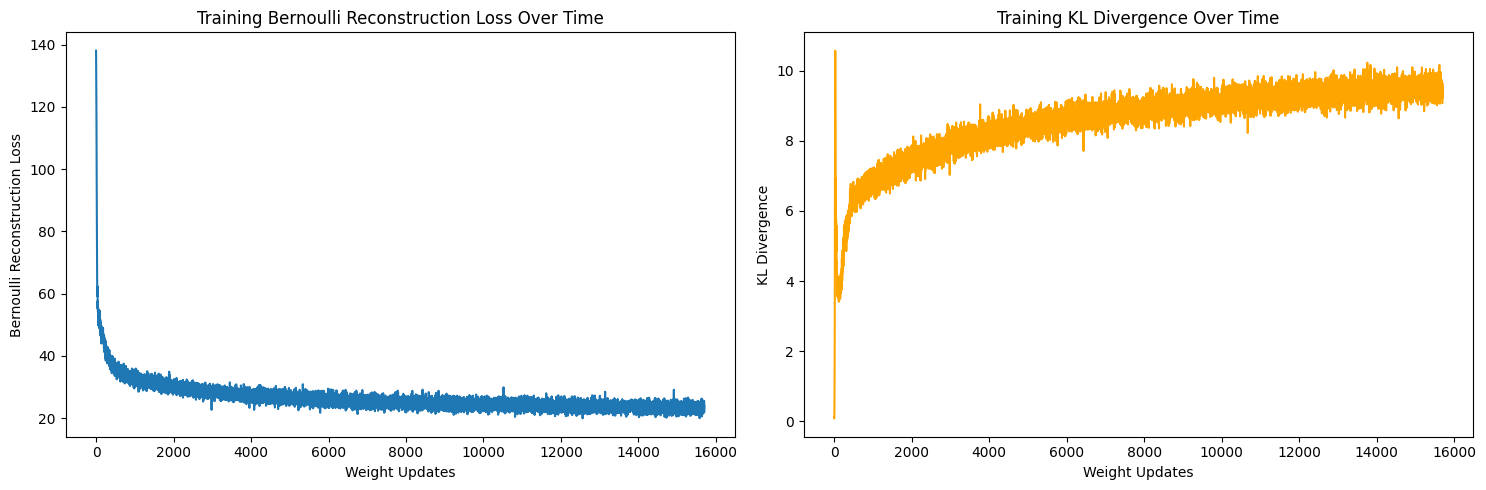

Training ELBO components plotted successfully.


In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Training Bernoulli Reconstruction Loss
axes[0].plot(range(len(training_recon_losses)), training_recon_losses)
axes[0].set_xlabel('Weight Updates')
axes[0].set_ylabel('Bernoulli Reconstruction Loss')
axes[0].set_title('Training Bernoulli Reconstruction Loss Over Time')

# Plot Training KL Divergence
axes[1].plot(range(len(training_kl_divergences)), training_kl_divergences, color='orange')
axes[1].set_xlabel('Weight Updates')
axes[1].set_ylabel('KL Divergence')
axes[1].set_title('Training KL Divergence Over Time')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

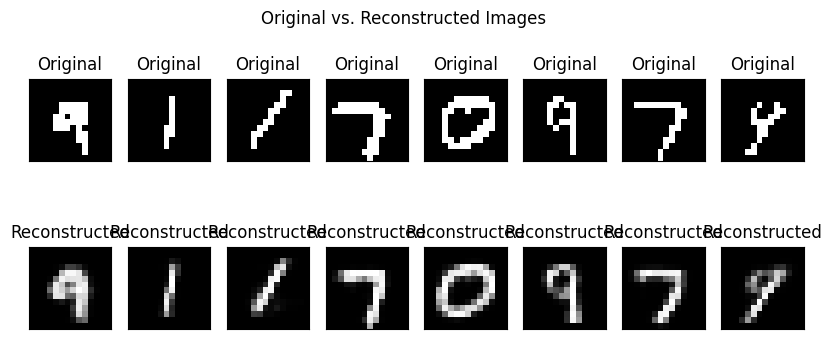

Reconstructed images displayed.


In [ ]:
import matplotlib.pyplot as plt

# 1. Set the VAE model to evaluation mode and disable gradient calculation
vae_model.eval()
with torch.no_grad():
    # 2. Obtain a batch of real images from the mnist_dataloader
    # Take the first batch from the dataloader for reconstruction visualization
    for batch_idx, data in enumerate(mnist_dataloader):
        real_images = data.to(device)
        break # Only take one batch

    # 3. Pass these real images through the vae_model to get their reconstructions
    reconstructed_images, _, _ = vae_model(real_images)

    # 4. Select a few original images and their corresponding reconstructed images to visualize.
    # For simplicity, let's visualize the first 8 images from the batch.
    num_display_images = 8

    # Reshape them from (batch_size, 196) to (batch_size, 14, 14) for plotting
    original_reshaped = real_images[:num_display_images].view(-1, 14, 14)
    reconstructed_reshaped = reconstructed_images[:num_display_images].view(-1, 14, 14)

    # 5. Use matplotlib.pyplot to display the original and reconstructed images side-by-side.
    plt.figure(figsize=(10, 4))
    for i in range(num_display_images):
        # Original Image
        ax = plt.subplot(2, num_display_images, i + 1)
        plt.imshow(original_reshaped[i].cpu().numpy(), cmap='gray')
        ax.set_title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed Image
        ax = plt.subplot(2, num_display_images, i + 1 + num_display_images)
        plt.imshow(reconstructed_reshaped[i].cpu().numpy(), cmap='gray')
        ax.set_title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle("Original vs. Reconstructed Images")
    plt.show()

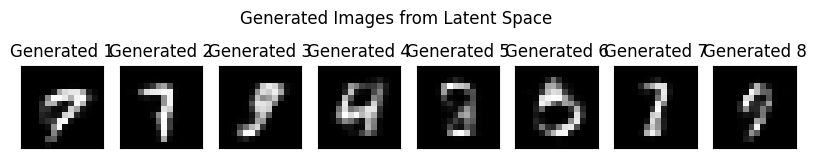

Generated images displayed.


In [ ]:
vae_model.eval()
with torch.no_grad():
    # 6. To generate new images, create a random latent vector z
    num_generated_images = 8 # Let's generate 8 new images
    # Sample from a standard normal distribution
    z_sample = torch.randn(num_generated_images, latent_dim).to(device)

    # 7. Pass this random z through the vae_model.decoder to generate new images
    generated_images = vae_model.decoder(z_sample)

    # Reshape the generated images from (num_generated_images, 196) to (num_generated_images, 14, 14)
    generated_reshaped = generated_images.view(-1, 14, 14)

    # 8. Display several of these newly generated images using matplotlib.pyplot in a grid format.
    plt.figure(figsize=(10, 2))
    for i in range(num_generated_images):
        ax = plt.subplot(1, num_generated_images, i + 1)
        plt.imshow(generated_reshaped[i].cpu().numpy(), cmap='gray')
        ax.set_title(f"Generated {i+1}")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle("Generated Images from Latent Space")
    plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import torch

# Ensure target_size and binary_threshold are defined from previous steps
# target_size = (14, 14)
# binary_threshold = 128

# 1. Resize x_test
# Add a channel dimension for tf.image.resize, then remove it
X_test_resized = tf.image.resize(np.expand_dims(x_test, axis=-1), target_size).numpy()
if X_test_resized.shape[-1] == 1:
    X_test_resized = X_test_resized.squeeze(axis=-1)

print(f"Shape of resized x_test: {X_test_resized.shape}")

# 2. Binarize the resized x_test images
X_test_binarized = (X_test_resized > binary_threshold).astype(np.float32)

print(f"Shape of binarized x_test: {X_test_binarized.shape}")

# 3. Convert to PyTorch Tensor
X_test_tensor = torch.tensor(X_test_binarized, dtype=torch.float32)

# 4. Flatten the PyTorch tensor
X_test_flattened_tensor = X_test_tensor.view(X_test_tensor.shape[0], -1)

print(f"Shape of flattened x_test tensor: {X_test_flattened_tensor.shape}")

# 5. Randomly select 100 images for periodic evaluation
num_validation_samples = 100

# Generate random indices
rng = np.random.default_rng(seed=42) # For reproducibility
validation_indices = rng.choice(X_test_flattened_tensor.shape[0], num_validation_samples, replace=False)

x_val_100_tensor = X_test_flattened_tensor[validation_indices]

print(f"Shape of x_val_100_tensor (100 validation samples): {x_val_100_tensor.shape}")

Shape of resized x_test: (10000, 14, 14)
Shape of binarized x_test: (10000, 14, 14)
Shape of flattened x_test tensor: torch.Size([10000, 196])
Shape of x_val_100_tensor (100 validation samples): torch.Size([100, 196])


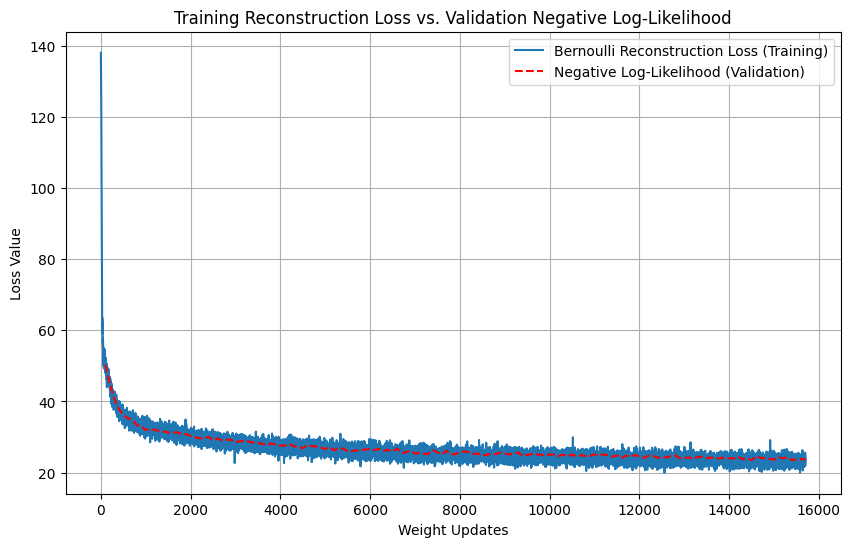

Training vs. Validation Log-Likelihood plot generated successfully.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure and axes object
plt.figure(figsize=(10, 6))

# Plot Training Bernoulli Reconstruction Loss
plt.plot(range(len(training_recon_losses)), training_recon_losses, label='Bernoulli Reconstruction Loss (Training)')

# Calculate x-axis values for validation_log_likelihoods
# Validation is performed every 100 weight updates
validation_x_values = np.arange(1, len(validation_log_likelihoods) + 1) * 100

# Plot Validation Negative Log-Likelihood
plt.plot(validation_x_values, validation_log_likelihoods, label='Negative Log-Likelihood (Validation)', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Weight Updates')
plt.ylabel('Loss Value')
plt.title('Training Reconstruction Loss vs. Validation Negative Log-Likelihood')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()